In [256]:
import sys
import torch
import torchviz
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [233]:
from torchvision import datasets, transforms

In [117]:
??torch.nn.Linear

Init signature:
torch.nn.Linear(
    in_features: int,
    out_features: int,
    bias: bool = True,
    device=None,
    dtype=None,
) -> None
Source:        
class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(*, H_{in})` where :math:`*` means any number of
          dimensions including none and :math:`H_{in} = \text{in\_features}`.
        - Output: :math:`(*, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

 

In [127]:
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

In [130]:
import urllib
from PIL import Image

In [48]:
torch.cuda.is_available()

False

In [2]:
sys.version_info

sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)

In [3]:
torch.__version__

'1.12.0'

In [361]:
#from vit_grad_rollout import VITAttentionGradRollout

model = torch.hub.load('facebookresearch/deit:main', 
'deit_tiny_patch16_224', pretrained=True)
# grad_rollout = VITAttentionGradRollout(model, discard_ratio=0.9, head_fusion='max')
# mask = grad_rollout(input_tensor, category_index=243)

Using cache found in /Users/46226/.cache/torch/hub/facebookresearch_deit_main


In [112]:
y = model(torch.ones(1, 3, 224, 224))

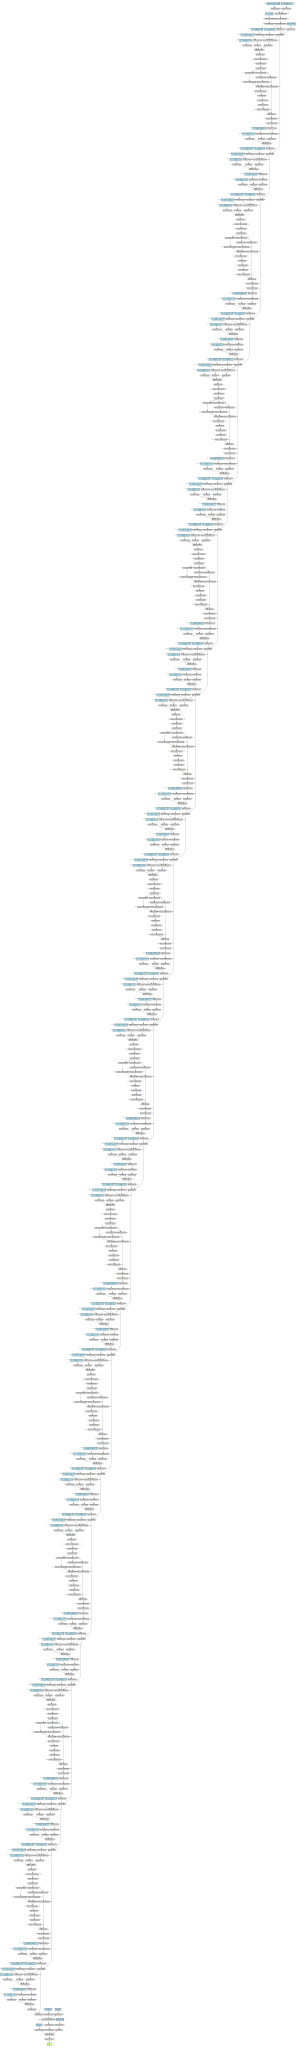

In [115]:
torchviz.make_dot(y.mean(), params=dict(list(model.named_parameters())))

In [128]:
config = resolve_data_config({}, model=model)
transform = create_transform(**config)

In [131]:
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)
img = Image.open(filename).convert('RGB')

In [147]:
transform(img).shape

torch.Size([3, 224, 224])

<AxesSubplot:>

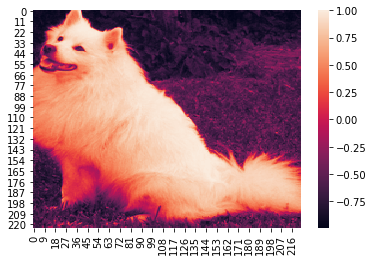

In [145]:
sns.heatmap(transform(img)[0])

In [ ]:
inp = transform(img).unsqueeze(0)

In [152]:
with torch.no_grad():
    out = model(inp)

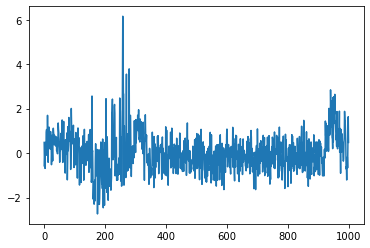

In [158]:
plt.plot(out[0])

<AxesSubplot:>

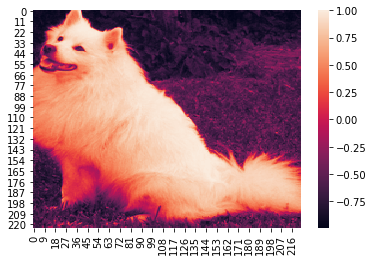

In [175]:
sns.heatmap(transform(img)[0])

In [163]:
url, filename = ("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", "imagenet_classes.txt")
urllib.request.urlretrieve(url, filename) 
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [168]:
out_np = out[0].numpy()

In [174]:
pd.Series(out_np, index=categories).sort_values(ascending=False)[:10]

Samoyed             6.154826
Pomeranian          4.360785
Arctic fox          3.788733
white wolf          3.551293
Great Pyrenees      2.950927
spaghetti squash    2.844265
chow                2.701859
keeshond            2.644722
banana              2.642757
papillon            2.568344
dtype: float32

In [323]:
def get_features(name, features_curr):
    def get_hook(model, input, output):
        features_curr[name] = output.detach()
    return get_hook

In [456]:
def get_activations(model, inp):
    features = {}
    handles = {}

    for name, module in model.named_modules():
        handles[name] = module.register_forward_hook(get_features(name, features))

    with torch.no_grad():
        out = model(inp).detach()

    for handle in handles:
        handles[handle].remove()
    return features

In [457]:
inp = transform(img).unsqueeze(0)
features = get_activations(model, inp)

In [461]:
img_rot = transforms.functional.rotate(img, angle=180)
inp_rot = transform(img_rot).unsqueeze(0)
features_rot = get_activations(model, inp_rot)

In [519]:
inp.max()

tensor(1.)

In [646]:
random_inp.mean()

tensor(3.5414e-05)

In [642]:
torch.rand(inp.shape).mean()

tensor(0.4996)

In [688]:
n_trials = 1000
rand_inp_shape = [n_trials] + list(inp.shape[1:])
random_inp = 2 * (torch.rand(rand_inp_shape) - 0.5)
features_avg = get_activations(model, random_inp)

for name in features_avg:
    features_avg[name] = features_avg[name].mean(axis=0).unsqueeze(0)

In [690]:
features_avg['patch_embed.proj'].detach().mean()

tensor(0.0061)

In [679]:
random_inp.shape

torch.Size([100, 3, 224, 224])

In [691]:
model.patch_embed.proj.weight.detach().min()

tensor(-0.2961)

In [ ]:
Wx + b

In [613]:
features_avg["patch_embed.proj"].shape

torch.Size([1, 192, 14, 14])

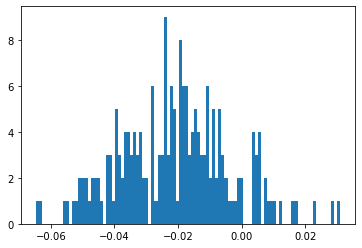

In [692]:
plt.hist(features_avg["patch_embed.proj"][0][0].flatten().numpy(), bins=100)
plt.show()

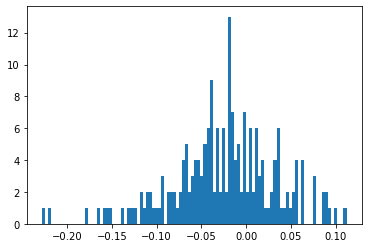

In [681]:
plt.hist(features_avg["patch_embed.proj"][0][0].flatten().numpy(), bins=100)
plt.show()

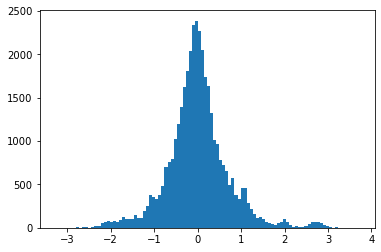

In [682]:
plt.hist(features["patch_embed.proj"][0].flatten().numpy(), bins=100)
plt.show()

In [693]:
model.patch_embed.proj.bias[0]

tensor(-0.0191, grad_fn=<SelectBackward0>)

In [617]:
model.patch_embed

PatchEmbed(
  (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
  (norm): Identity()
)

In [675]:
random_inp.shape#[:, 0, 0, 0]

torch.Size([1, 3, 224, 224])

In [694]:
random_inp.mean(axis=0)#.unsqueeze(0)[0, :, :16, :16]

tensor([[[ 0.0016, -0.0285,  0.0150,  ..., -0.0061,  0.0198, -0.0043],
         [ 0.0035, -0.0084,  0.0375,  ..., -0.0036,  0.0108,  0.0118],
         [ 0.0267,  0.0015,  0.0305,  ..., -0.0107,  0.0156, -0.0118],
         ...,
         [ 0.0050, -0.0153,  0.0185,  ..., -0.0171,  0.0106,  0.0253],
         [ 0.0309, -0.0170,  0.0209,  ..., -0.0120,  0.0290,  0.0247],
         [ 0.0437, -0.0207,  0.0231,  ..., -0.0064, -0.0179, -0.0188]],

        [[-0.0129,  0.0070,  0.0264,  ...,  0.0011,  0.0044, -0.0277],
         [ 0.0319, -0.0012,  0.0076,  ..., -0.0090,  0.0110, -0.0138],
         [-0.0153, -0.0169, -0.0066,  ...,  0.0053, -0.0141,  0.0053],
         ...,
         [ 0.0156, -0.0258,  0.0311,  ...,  0.0079,  0.0078,  0.0314],
         [-0.0003,  0.0189,  0.0039,  ..., -0.0007,  0.0414, -0.0170],
         [-0.0159, -0.0367,  0.0038,  ..., -0.0053, -0.0260, -0.0032]],

        [[ 0.0121,  0.0083, -0.0183,  ...,  0.0281,  0.0448,  0.0066],
         [ 0.0323,  0.0656, -0.0318,  ...,  0

In [695]:
model.patch_embed.proj.weight.shape

torch.Size([192, 3, 16, 16])

In [699]:
(model.patch_embed.proj.weight[0] * random_inp[:, :, :16, :16].mean(axis=0)).sum() + model.patch_embed.proj.bias[0]

tensor(0.0309, grad_fn=<AddBackward0>)

In [697]:
features_avg['patch_embed.proj'][0][0][0][0]

tensor(0.0309)

In [593]:
def corr_features(features1, features2):
    return {name: torch.corrcoef(torch.stack([features1[name].flatten(), features2[name].flatten()]))[0][1].numpy()[()] for name in features1}

In [700]:
def corr_center_features(features1, features2):
    return {name: torch.corrcoef(torch.stack([(features1[name] - features_avg[name]).flatten(),
                                              (features2[name] - features_avg[name]).flatten()]))[0][1].numpy()[()] for name in features1}

In [701]:
corrs = corr_center_features(features, features_rot)

<AxesSubplot:>

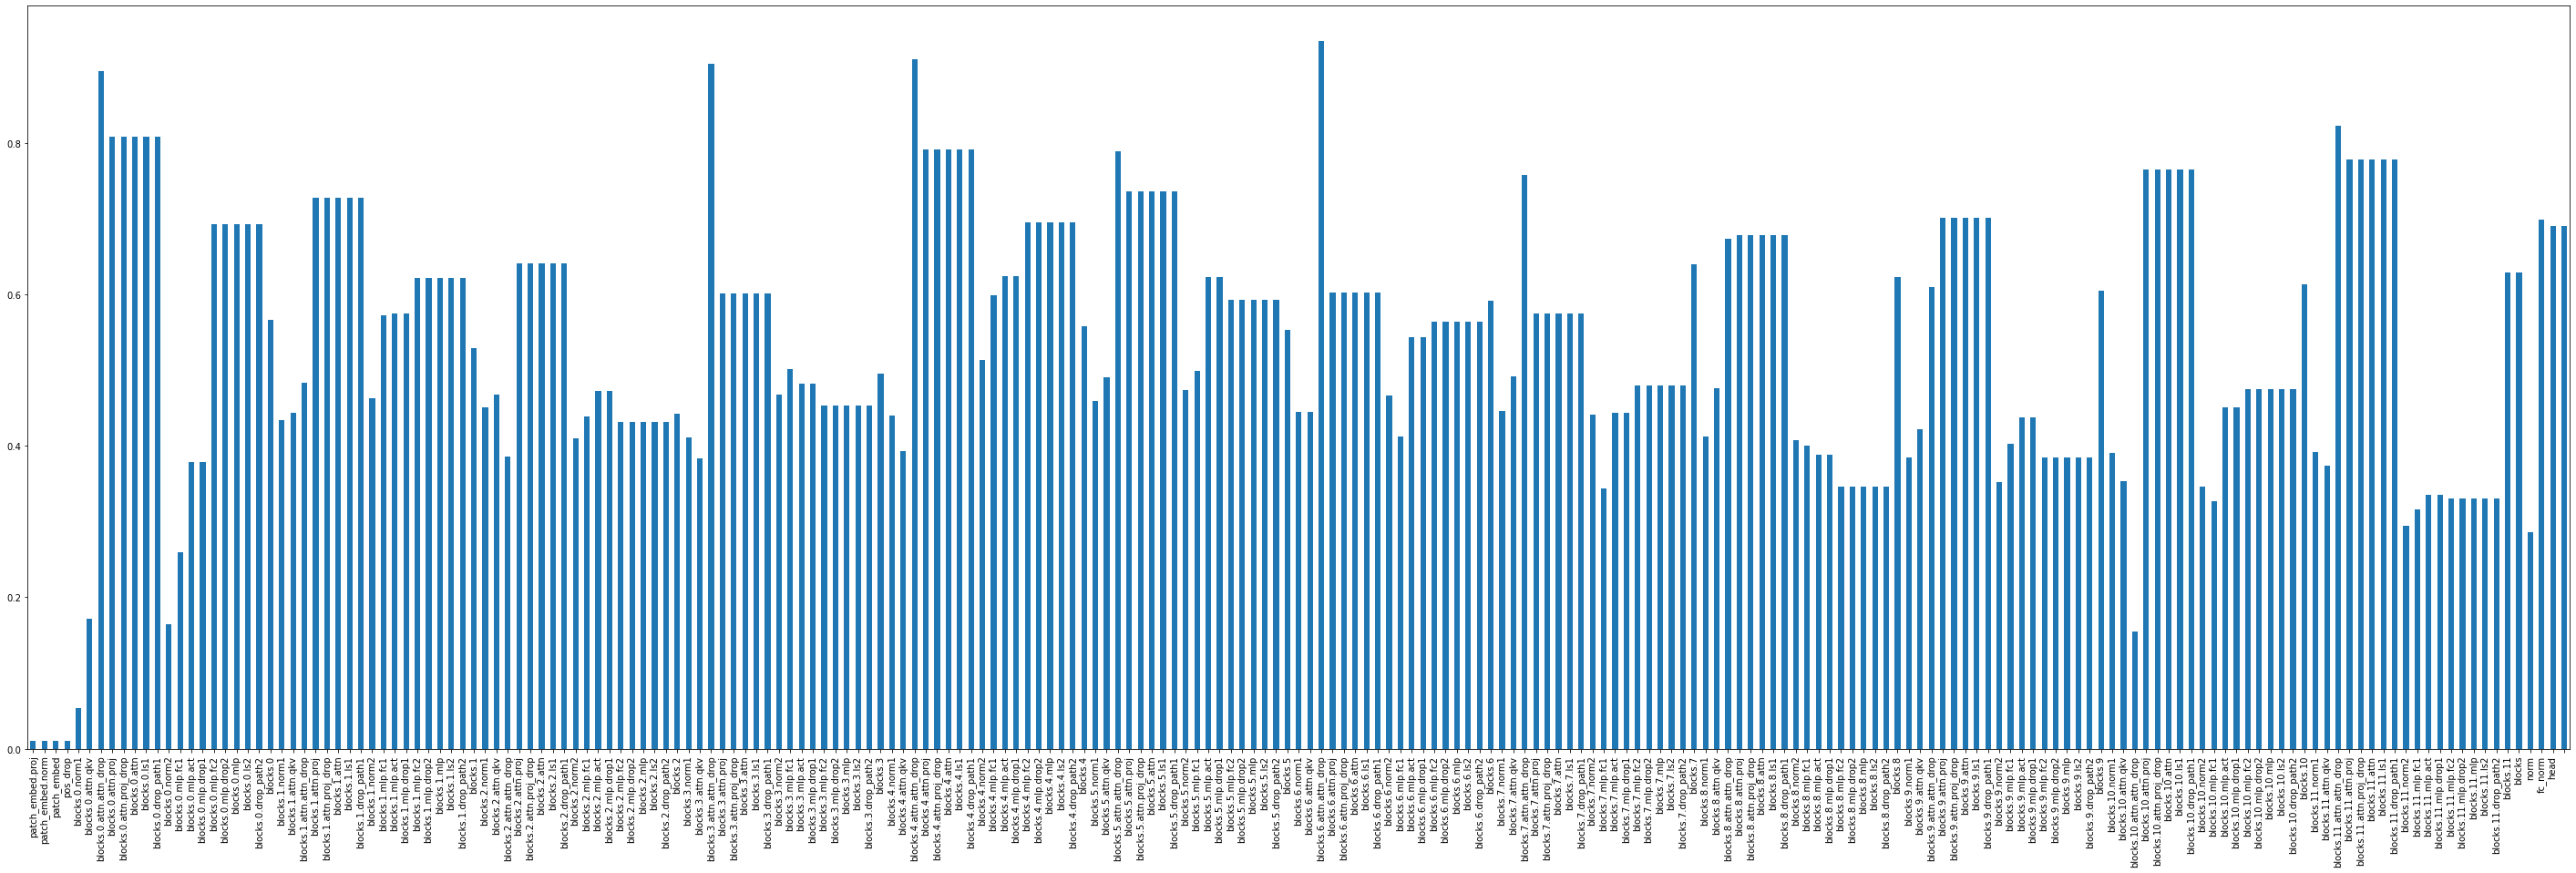

In [704]:
pd.Series(corrs).plot.bar(figsize=(50, 15))

In [713]:
model.blocks[0]

Block(
  (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=192, out_features=576, bias=True)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=192, out_features=192, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (ls1): Identity()
  (drop_path1): Identity()
  (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=192, out_features=768, bias=True)
    (act): GELU(approximate=none)
    (drop1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=768, out_features=192, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (ls2): Identity()
  (drop_path2): Identity()
)

In [716]:
?torch.nn.LayerNorm

Init signature:
torch.nn.LayerNorm(
    normalized_shape: Union[int, List[int], torch.Size],
    eps: float = 1e-05,
    elementwise_affine: bool = True,
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies Layer Normalization over a mini-batch of inputs as described in
the paper `Layer Normalization <https://arxiv.org/abs/1607.06450>`__

.. math::
    y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta

The mean and standard-deviation are calculated over the last `D` dimensions, where `D`
is the dimension of :attr:`normalized_shape`. For example, if :attr:`normalized_shape`
is ``(3, 5)`` (a 2-dimensional shape), the mean and standard-deviation are computed over
the last 2 dimensions of the input (i.e. ``input.mean((-2, -1))``).
:math:`\gamma` and :math:`\beta` are learnable affine transform parameters of
:attr:`normalized_shape` if :attr:`elementwise_affine` is ``True``.
The standard-deviation is calculated via the biased estimator, equivale

In [707]:
pd.Series(corrs)[:50]

patch_embed.proj           0.010228
patch_embed.norm           0.010228
patch_embed                0.010228
pos_drop                   0.010228
blocks.0.norm1             0.053435
blocks.0.attn.qkv          0.171124
blocks.0.attn.attn_drop    0.895153
blocks.0.attn.proj         0.808491
blocks.0.attn.proj_drop    0.808491
blocks.0.attn              0.808491
blocks.0.ls1               0.808491
blocks.0.drop_path1        0.808491
blocks.0.norm2             0.164487
blocks.0.mlp.fc1           0.259046
blocks.0.mlp.act           0.378650
blocks.0.mlp.drop1         0.378650
blocks.0.mlp.fc2           0.692171
blocks.0.mlp.drop2         0.692171
blocks.0.mlp               0.692171
blocks.0.ls2               0.692171
blocks.0.drop_path2        0.692171
blocks.0                   0.566294
blocks.1.norm1             0.433586
blocks.1.attn.qkv          0.443859
blocks.1.attn.attn_drop    0.482769
blocks.1.attn.proj         0.728093
blocks.1.attn.proj_drop    0.728093
blocks.1.attn              0

In [422]:
torch.corrcoef(torch.stack([inp.flatten(), inp_rot.flatten()]))

tensor([[1.0000, 0.0320],
        [0.0320, 1.0000]])

In [381]:
features_rot['head'][0, :10], features['head'][0, :10]

(tensor([ 0.9272,  0.0599, -0.5560, -0.6925,  0.4169,  0.2021, -0.1951,  1.0260,
          0.9886, -0.2918]),
 tensor([ 0.4829, -0.5970, -0.1271, -0.6865,  0.4824,  0.3022,  0.2951,  0.9423,
          1.0611, -0.0966]))

In [426]:
torch.corrcoef(torch.stack([features['patch_embed.proj'].flatten(), features_rot['patch_embed.proj'].flatten()]))

tensor([[1.0000, 0.8449],
        [0.8449, 1.0000]])

In [428]:
features['patch_embed.proj'].shape

torch.Size([1, 192, 14, 14])

In [429]:
features['patch_embed.proj'][0]

tensor([[[ 1.0353e-01,  2.8077e-01,  9.3840e-01,  ...,  4.8275e-02,
           4.3524e-01,  5.8038e-02],
         [-9.9950e-03, -1.1955e+00, -6.3926e-02,  ..., -4.0346e-02,
          -1.6597e-01, -5.7608e-02],
         [ 7.2042e-01, -4.6010e-02, -3.9963e-01,  ...,  1.7921e-01,
          -3.0398e-02,  1.3250e-02],
         ...,
         [ 3.8648e-02,  2.1709e-01, -2.7963e-02,  ..., -1.9758e-02,
          -4.1613e-02, -6.2880e-02],
         [ 2.1845e-02, -8.2756e-01, -1.6870e-01,  ..., -1.3852e-01,
           8.5895e-02,  4.9327e-03],
         [-4.7912e-02,  8.8904e-01, -1.3696e-01,  ...,  3.0801e-01,
           2.7582e-01,  5.0117e-01]],

        [[ 1.9811e-02, -7.5995e-02,  4.7853e-01,  ...,  8.9465e-02,
           1.0430e-01, -9.3518e-02],
         [-7.2994e-02,  3.3295e-01, -8.8022e-02,  ...,  5.0349e-02,
          -2.9088e-01, -3.2232e-01],
         [ 6.6349e-03,  2.0670e-01, -3.9162e-01,  ..., -6.0579e-01,
          -2.0257e-01, -5.8402e-01],
         ...,
         [-6.9451e-02, -6

In [430]:
model.patch_embed

PatchEmbed(
  (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
  (norm): Identity()
)

<AxesSubplot:>

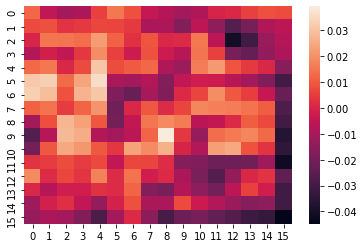

In [443]:
sns.heatmap(model.patch_embed.proj.weight[10].detach().numpy()[2])

In [444]:
{name: features[name].shape for name in features}

{'patch_embed.proj': torch.Size([1, 192, 14, 14]),
 'patch_embed.norm': torch.Size([1, 196, 192]),
 'patch_embed': torch.Size([1, 196, 192]),
 'pos_drop': torch.Size([1, 197, 192]),
 'blocks.0.norm1': torch.Size([1, 197, 192]),
 'blocks.0.attn.qkv': torch.Size([1, 197, 576]),
 'blocks.0.attn.attn_drop': torch.Size([1, 3, 197, 197]),
 'blocks.0.attn.proj': torch.Size([1, 197, 192]),
 'blocks.0.attn.proj_drop': torch.Size([1, 197, 192]),
 'blocks.0.attn': torch.Size([1, 197, 192]),
 'blocks.0.ls1': torch.Size([1, 197, 192]),
 'blocks.0.drop_path1': torch.Size([1, 197, 192]),
 'blocks.0.norm2': torch.Size([1, 197, 192]),
 'blocks.0.mlp.fc1': torch.Size([1, 197, 768]),
 'blocks.0.mlp.act': torch.Size([1, 197, 768]),
 'blocks.0.mlp.drop1': torch.Size([1, 197, 768]),
 'blocks.0.mlp.fc2': torch.Size([1, 197, 192]),
 'blocks.0.mlp.drop2': torch.Size([1, 197, 192]),
 'blocks.0.mlp': torch.Size([1, 197, 192]),
 'blocks.0.ls2': torch.Size([1, 197, 192]),
 'blocks.0.drop_path2': torch.Size([1, 197

In [423]:
features

{'patch_embed.proj': tensor([[[[ 1.0353e-01,  2.8077e-01,  9.3840e-01,  ...,  4.8275e-02,
             4.3524e-01,  5.8038e-02],
           [-9.9950e-03, -1.1955e+00, -6.3926e-02,  ..., -4.0346e-02,
            -1.6597e-01, -5.7608e-02],
           [ 7.2042e-01, -4.6010e-02, -3.9963e-01,  ...,  1.7921e-01,
            -3.0398e-02,  1.3250e-02],
           ...,
           [ 3.8648e-02,  2.1709e-01, -2.7963e-02,  ..., -1.9758e-02,
            -4.1613e-02, -6.2880e-02],
           [ 2.1845e-02, -8.2756e-01, -1.6870e-01,  ..., -1.3852e-01,
             8.5895e-02,  4.9327e-03],
           [-4.7912e-02,  8.8904e-01, -1.3696e-01,  ...,  3.0801e-01,
             2.7582e-01,  5.0117e-01]],
 
          [[ 1.9811e-02, -7.5995e-02,  4.7853e-01,  ...,  8.9465e-02,
             1.0430e-01, -9.3518e-02],
           [-7.2994e-02,  3.3295e-01, -8.8022e-02,  ...,  5.0349e-02,
            -2.9088e-01, -3.2232e-01],
           [ 6.6349e-03,  2.0670e-01, -3.9162e-01,  ..., -6.0579e-01,
            -2.0257

In [383]:
features['patch_embed.proj'][0][0][0]

tensor([ 0.1035,  0.2808,  0.9384, -0.2203, -0.1288, -0.0159,  0.1823,  0.1595,
        -0.1742,  0.1406, -0.1049,  0.0483,  0.4352,  0.0580])

In [276]:
np.correlate(out[0].numpy(), out_rot[0].numpy())

array([609.5912], dtype=float32)

tensor([[1.0000, 0.7463],
        [0.7463, 1.0000]])

In [263]:
torch.corrcoef(out[0], out_rot[0])

TypeError: corrcoef() takes 1 positional argument but 2 were given

In [227]:
{key: features[key].shape for key in features}

{'patch_embed': torch.Size([1, 196, 192]),
 'patch_embed.proj': torch.Size([1, 192, 14, 14]),
 'patch_embed.norm': torch.Size([1, 196, 192]),
 'pos_drop': torch.Size([1, 197, 192]),
 'blocks.0.norm1': torch.Size([1, 197, 192]),
 'blocks.0.attn.qkv': torch.Size([1, 197, 576]),
 'blocks.0.attn.attn_drop': torch.Size([1, 3, 197, 197]),
 'blocks.0.attn.proj': torch.Size([1, 197, 192]),
 'blocks.0.attn.proj_drop': torch.Size([1, 197, 192]),
 'blocks.0.attn': torch.Size([1, 197, 192]),
 'blocks.0.ls1': torch.Size([1, 197, 192]),
 'blocks.0.drop_path1': torch.Size([1, 197, 192]),
 'blocks.0.norm2': torch.Size([1, 197, 192]),
 'blocks.0.mlp.fc1': torch.Size([1, 197, 768]),
 'blocks.0.mlp.act': torch.Size([1, 197, 768]),
 'blocks.0.mlp.drop1': torch.Size([1, 197, 768]),
 'blocks.0.mlp.fc2': torch.Size([1, 197, 192]),
 'blocks.0.mlp.drop2': torch.Size([1, 197, 192]),
 'blocks.0.mlp': torch.Size([1, 197, 192]),
 'blocks.0.ls2': torch.Size([1, 197, 192]),
 'blocks.0.drop_path2': torch.Size([1, 197

<AxesSubplot:>

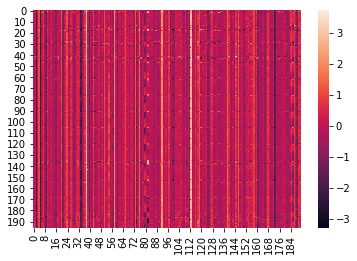

In [232]:
sns.heatmap(features["patch_embed"][0].numpy())

In [183]:
modules = list(model.modules())

In [198]:
list(model.named_modules())[1]

('patch_embed',
 PatchEmbed(
   (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
   (norm): Identity()
 ))

In [14]:
params = [x for x in model.named_parameters()]

In [31]:
children = [x for x in model.children()]

In [30]:
[x for x in c1.children()]

[Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16)), Identity()]

In [36]:
c1 = children[1]

In [72]:
torch.ones(1) + torch.ones(1)

tensor([2.])

In [91]:
a = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, 7, requires_grad=True)

In [92]:
c = a @ b

In [93]:
c.sum()

tensor(0.9843, grad_fn=<SumBackward0>)

In [94]:
d = c.sum()
d.backward()

In [96]:
a.grad

tensor([[-3.0545,  0.3098, -2.6544],
        [-3.0545,  0.3098, -2.6544],
        [-3.0545,  0.3098, -2.6544],
        [-3.0545,  0.3098, -2.6544],
        [-3.0545,  0.3098, -2.6544]])

In [59]:
p1 = next(next(children[0].children()).parameters())

In [67]:
p1.data.shape

torch.Size([192, 3, 16, 16])